In [21]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt
import bs4
import statsmodels.formula.api as smf
from datetime import datetime

%matplotlib inline

#nice defaults for matplotlib
from matplotlib import rcParams

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

#Lab 8: Election Prediction



##Election scraping

When was the election?

In [2]:
#Wikipedia page with table of election dates
theurl = "http://en.wikipedia.org/wiki/Election_Day_(United_States)"

#Grab table from page. Use "Midterm" as a unique identifier of the table
#we want. Grab the first returned dataframe.
wikitable = pd.read_html(theurl, match="Midterm", header=0)[0]
#Bingo. But note that the dates are automatically set to 2014.
print wikitable

    Year         Day                        Details          Type
0   2000  November 7  United States elections, 2000  Presidential
1   2001  November 6  United States elections, 2001      Off-year
2   2002  November 5  United States elections, 2002       Midterm
3   2003  November 4  United States elections, 2003      Off-year
4   2004  November 2  United States elections, 2004  Presidential
5   2005  November 8  United States elections, 2005      Off-year
6   2006  November 7  United States elections, 2006       Midterm
7   2007  November 6  United States elections, 2007      Off-year
8   2008  November 4  United States elections, 2008  Presidential
9   2009  November 3  United States elections, 2009      Off-year
10  2010  November 2  United States elections, 2010       Midterm
11  2011  November 8  United States elections, 2011      Off-year
12  2012  November 6  United States elections, 2012  Presidential
13  2013  November 5  United States elections, 2013      Off-year
14  2014  

In [20]:
def set_year(dateobj, year):
    month, day = dateobj.split()
    d2 = ' '.join([day.zfill(2), month, str(year)])
    return d2

wikitable['electionday'] = wikitable.apply(lambda r: set_year(r.values[1], r.values[0]), axis=1)
wikitable.head()

,Year,Day,Details,Type,electionday
0,2000,November 7,"United States elections, 2000",Presidential,07 November 2000
1,2001,November 6,"United States elections, 2001",Off-year,06 November 2001
2,2002,November 5,"United States elections, 2002",Midterm,05 November 2002
3,2003,November 4,"United States elections, 2003",Off-year,04 November 2003
4,2004,November 2,"United States elections, 2004",Presidential,02 November 2004


In [24]:
#Grab all data
filedates = ["2002_2008", "2010", "2012"]
pollstercsvs = [pd.read_csv("pollster_cleaned_%s.csv"%fname, parse_dates=['end.date']) 
                for fname in filedates]
#Paste them together
oldpolls = pd.concat(pollstercsvs)
oldpolls['end.date']

oldpolls = pd.merge(oldpolls, wikitable, how="inner", left_on="year", right_on="Year")

#Filter to senate races
oldpolls = oldpolls.ix[oldpolls.race.str.contains("Sen"),:]

#Compute number of days between poll's end date and election day.
oldpolls['day'] = oldpolls.apply(lambda x: (x['end.date']-datetime.strptime(x['electionday'], '%d %B %Y')).days, axis=1)
#Filter down to polls taken within a year of the election.
oldpolls = oldpolls.ix[(oldpolls.day <= 0) & (oldpolls.day >= -365),:]

Deal with independents. Make them dems or republicans depending on who the best competitor is.

In [25]:
def grab_greater(df, focus, champ, chal):
    return np.where((df[chal] > df[focus]) & (df[champ] > df[focus]),
                    df[chal], df[focus])

oldpolls['real.dem2'] = grab_greater(oldpolls, 'real.dem', 'real.rep', 'real.oth')
oldpolls['real.rep2'] = grab_greater(oldpolls, 'real.rep', 'real.dem', 'real.oth')

oldpolls['vote.dem2'] = grab_greater(oldpolls, 'vote.dem', 'vote.rep', 'vote.oth')
oldpolls['vote.rep2'] = grab_greater(oldpolls, 'vote.rep', 'vote.dem', 'vote.oth')

Now compute differences and bias. Here "bias" is a poll's prediction of the Republican's advantage minus the Republican's actual win margin. 

In [26]:
oldpolls['diff'] = oldpolls['vote.rep2']-oldpolls['vote.dem2']
oldpolls['reald'] = oldpolls['real.rep2']-oldpolls['real.dem2']
oldpolls['bias'] = oldpolls['diff']-oldpolls['reald']

Note that there are some flipped values.

In [27]:
print oldpolls.ix[oldpolls.bias.abs() >= 50,["vote.rep2", "vote.dem2", "real.rep2", "real.dem2"]]

      vote.rep2  vote.dem2  real.rep2  real.dem2
4651       32.0       65.0      63.36      36.52


Drop these polls.

In [28]:
oldpolls = oldpolls.ix[oldpolls.bias.abs() < 50,:]

Now make some exploratory plots. First, plot the number of polls per week per race.

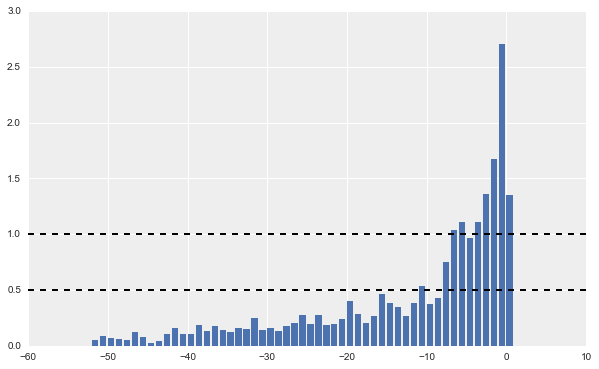

In [29]:
#`value_counts` counts the number of times each value is repeated in a series.
day_table = (oldpolls['day']/7).round().value_counts()
#`nunique` counts the number of unique values in a series.
num_races = oldpolls['race'].nunique()
plt.bar(day_table.index, day_table/num_races)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.axhline(y=1, color='black', linestyle='--')
plt.show()

In [30]:
cutoff = -60
oldpolls = oldpolls.ix[oldpolls.day > cutoff,:]

##Which polls should we keep?

We might want to filter out certain unreliable polls. Explore different groupings of polls (for example, by polling company, party affiliation of the pollster, or sampled population) to see if any stick out in terms of prediction bias.

###Grouping by pollster.

Boxplots give a good graphical exploration.

/Users/tomasz.dobrzycki/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tomasz.dobrzycki/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


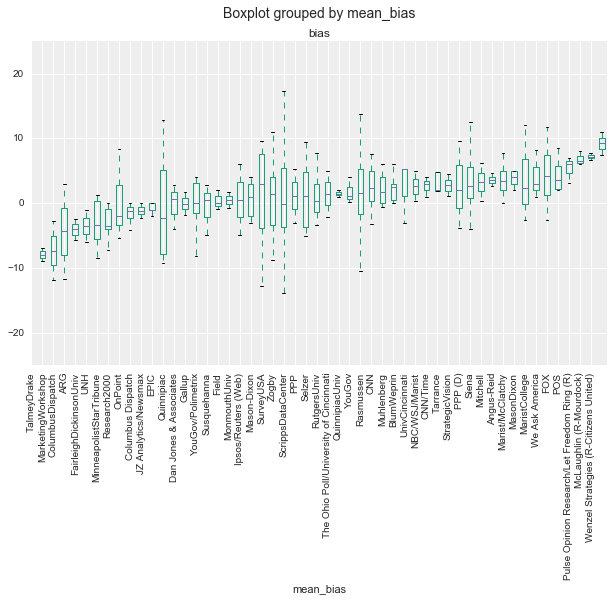

In [31]:
#For this analysis, consider only polls within a week of the election.
tmppolls = oldpolls.ix[oldpolls.day >= -7,]

#Compute number of polls taken by each pollster, in a format that lets you save this
#back to the original dataframe. Every poll corresponding to a given pollster will
#have the same value for 'npolls' -- `transform` creates these repeats for you.
tmppolls['npolls'] = tmppolls.groupby("pollster")['pollster'].transform(len)
#Only analyze pollsters with more than 2 polls.
tmppolls = tmppolls.ix[tmppolls.npolls >= 2,]

#Compute mean bias of each pollster. Save this back to the original dataframe.
tmppolls['mean_bias'] = tmppolls.groupby("pollster")['bias'].transform(np.mean)
#Make boxplot grouped by and sorted by mean bias.
tmppolls.boxplot("bias", by="mean_bias", rot=90)

#To get the right labels on the boxplot, recompute bias, but this time in a way
#that only returns one number per poll. `aggregate` only returns one number per
#pollster group.
pollster_bias = tmppolls.groupby("pollster")['bias'].aggregate(np.mean)
#Sort the pollster biases, then plot their indices to label the boxplot.
pollster_bias.sort()
plt.xticks(np.arange(len(pollster_bias)), pollster_bias.index, fontsize=10)
plt.ylim((-25,25))
plt.show()

We can also explore these biases using a linear regression to explain `bias in terms of the categorical variable `pollster`.

In [32]:
import statsmodels.formula.api as smf

pollster_anova = smf.ols(formula="bias ~ pollster - 1", data=tmppolls).fit()
pollster_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     1.419
Date:                Thu, 04 Aug 2016   Prob (F-statistic):             0.0353
Time:                        15:31:40   Log-Likelihood:                -1539.3
No. Observations:                 503   AIC:                             3183.
Df Residuals:                     451   BIC:                             3402.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
pollster[ARG]                                            -4.0400      3.855     -1.048      0.295       -11.616     3.536
pollster[Angus-Reid]                                      3.6800      2.438      1.509      0.132        -1.111     8.471
pollster[BlumWeprin]                                      2.5167      3.148      0.800      0.424        -3.669     8.702
pollster[CNN]                                             2.2875      2.726      0.839      0.402        -3.069     7.644
pollster[CNN/Time]                                        2.7400      2.438      1.124      0.262        -2.051     7.531
pollster[Columbus Dispatch]                              -1.1500      3.855     -0.298      0.766        -8.726     6.426
pollster[ColumbusDispatch]                               -4.3450      3.855     -1.127      0.260       -11.921     3.231
pollster[Dan Jones & Associates]                         -0.0500      3.855     -0.013      0.990        -7.626     7.526
pollster[EPIC]                                           -0.2750      2.726     -0.101      0.920        -5.632     5.082
pollster[FOX]                                             4.4500      2.726      1.633      0.103        -0.907     9.807
pollster[FairleighDickinsonUniv]                         -3.4450      3.855     -0.894      0.372       -11.021     4.131
pollster[Field]                                           0.5250      3.855      0.136      0.892        -7.051     8.101
pollster[Gallup]                                         -0.0250      1.724     -0.015      0.988        -3.413     3.363
pollster[Ipsos/Reuters (Web)]                             0.6111      1.285      0.476      0.635        -1.914     3.136
pollster[JZ Analytics/Newsmax]                           -0.4444      1.817     -0.245      0.807        -4.016     3.127
pollster[Marist/McClatchy]                                3.8000      2.726      1.394      0.164        -1.557     9.157
pollster[MaristCollege]                                   4.0933      3.148      1.300      0.194        -2.092    10.279
pollster[MarketingWorkshop]                              -7.2900      3.855     -1.891      0.059       -14.866     0.286
pollster[Mason-Dixon]                                     0.7250      2.726      0.266      0.790        -4.632     6.082
pollster[MasonDixon]                                      4.0093      1.012      3.960      0.000         2.020     5.999
pollster[McLaughlin (R-Mourdock)]                         7.2000      3.855      1.868      0.062        -0.376    14.776
pollster[MinneapolistStarTribune]                        -3.0820      2.438     -1.264      0.207        -7.873     1.709
pollster[Mitchell]               

###Group by Party Affiliation

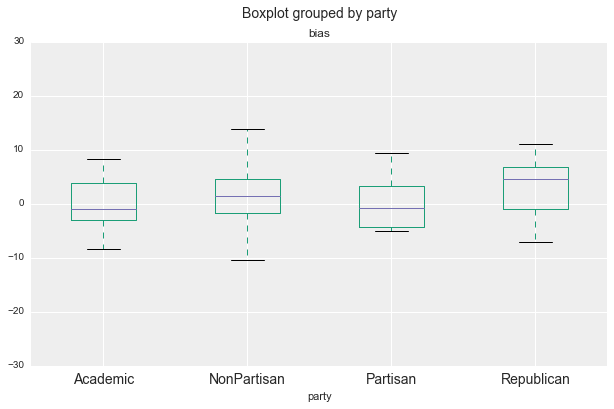

In [33]:
tmppolls.boxplot("bias", by="party")
plt.show()

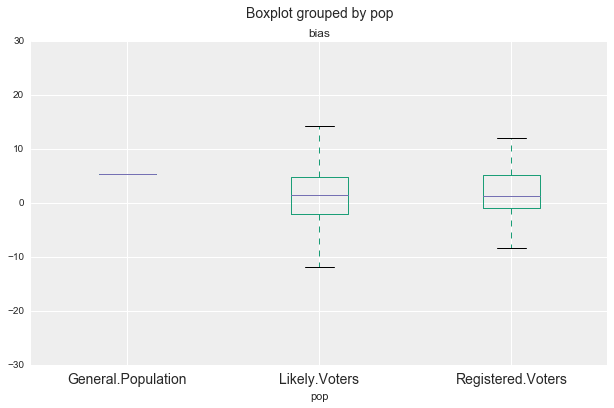

In [34]:
party_anova = smf.ols(formula="bias ~ party - 1", data=tmppolls).fit()
party_anova.summary()
tmppolls.boxplot("bias", by="pop")
plt.show()

###Group by sampled population

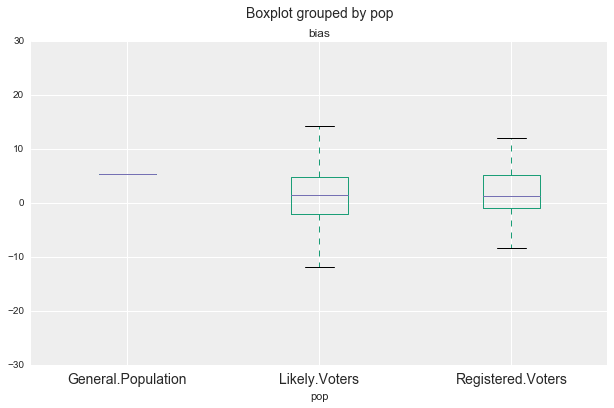

In [35]:
tmppolls.boxplot("bias", by="pop")
plt.show()

In [36]:
pop_anova = smf.ols(formula="bias ~ pop - 1", data=tmppolls).fit()
pop_anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   bias   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.4760
Date:                Thu, 04 Aug 2016   Prob (F-statistic):              0.622
Time:                        15:31:59   Log-Likelihood:                -1573.5
No. Observations:                 502   AIC:                             3153.
Df Residuals:                     499   BIC:                             3166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
pop[General.Population]     5.3100      5.577      0.952      0.341        -5.647    16.267
pop[Likely.Voters]          1.3089      0.262      4.990      0.000         0.794     1.824
pop[Registered.Voters]      1.8731      0.797      2.351      0.019         0.308     3.438
==============================================================================
Omnibus:                       35.247   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.184
Skew:                          -0.187   Prob(JB):                     2.94e-27
Kurtosis:                       5.388   Cond. No.                         21.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Subset down to likely voters.

In [37]:
oldpolls = oldpolls.ix[(~oldpolls['pop'].isnull()) & (oldpolls['pop'].str.contains("Likely")),:]

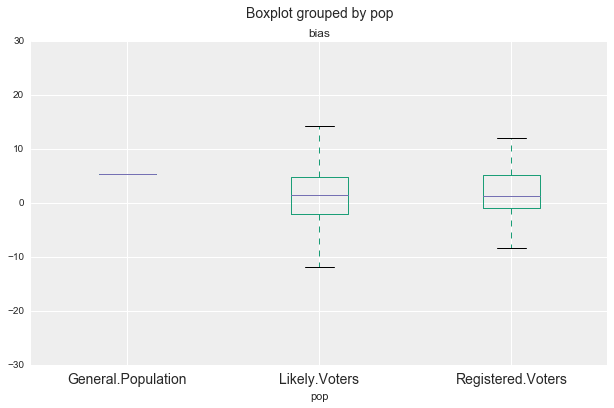

In [38]:
party_anova = smf.ols(formula="bias ~ party - 1", data=tmppolls).fit()
party_anova.summary()
tmppolls.boxplot("bias", by="pop")
plt.show()

##A (Not Great) Predictive Model

The following code implements a prediction strategy that takes all of the polls for given races and generates a point prediction and predicted standard error. The model itself is fairly basic and does not take into account any of the poll aggregation concerns covered in lab. Hint: Set the `plotme` variable to `True` if you'd like to see the model fit for each race.

In [39]:
import patsy
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#Cutoff for number of polls to perform "complex" prediction
#If fewer than minN polls, just average all polls together
#If more, use a spline fit to try to detect a trend.
minN = 15
#Plot the poll history, model fit, and error bar for each race, or not.
plotme= False
results = []

#Group the polls by race.
oldpolls_groups = oldpolls.groupby("race")

#Step through, group by group. For each loop iteration:
#race is assigned the name of the current group's race
#oldpolls_small is assigned the dataframe corresponding to that group.
for race, oldpolls_small in oldpolls_groups:
    #Check whether to do the simple or spline fit
    do_spline = oldpolls_small.shape[0] > minN
   
    #Simple fit first
    if not do_spline:
        data = oldpolls_small['diff']
        #Estimate is mean of all polls.
        #Note that this ignores sample sizes, pollster quality, etc.
        pred = np.mean(data)
        #Standard error is the standard deviation of the sample mean
        pred_se = np.sqrt(np.var(data)*(1/float(oldpolls_small.shape[0])))
    
    #More complex fit does a spline regression
    #Despite being "fancier", this approach also ignores samples sizes, pollster quality, etc.
    else:
        #Build a bunch of smooth functions of time. Throw these into a regression.
        spline_mat = patsy.dmatrix("cr(day-1, df=4)", data=oldpolls_small)
        pollfit = sm.OLS(oldpolls_small['diff'], spline_mat).fit()

        #Use the same function generator to create a representation of election day.
        #We will throw this into the regression model to get an estimate for election day.
        predmat = patsy.build_design_matrices([spline_mat.design_info.builder],
                                        pd.DataFrame({'day': [0]}))[0]

        #Get the prediction
        pred = pollfit.predict(predmat)[0]
        #Predicted standard error formula for regressions, when you expect the future datapoint to have
        #no sampling noise.
        pred_se =  np.sqrt(np.dot(predmat, np.dot(pollfit.cov_params(), predmat.T)).diagonal())[0]
    
    #Compare to the true result
    result = oldpolls_small['reald'].iloc[0]
    
    #Construct a 99% predictive interval. Check whether it contains the true result.
    pred_interval = pred+pred_se*np.array([-2.54, 2.54])
    covers = result > pred_interval[0] and result < pred_interval[1]

    #Optional plotting functionality
    if plotme:
        #Plot the polling data.
        plt.scatter(oldpolls_small['day'], oldpolls_small['diff'])
        #Draw a line representing the outcome.
        plt.axhline(result, color='black', linestyle='--')
        
        #Draw the model fit.
        if do_spline:
            order = np.array(oldpolls_small['day'].values.argsort())
            plt.plot(oldpolls_small['day'].values[order], np.array(pollfit.predict())[order], color='orange')
        else:
            plt.plot([oldpolls['day'].min(), oldpolls['day'].max()], [pred, pred], color='orange')
        
        #Plot the model prediction
        plt.scatter(0, pred)
        #Draw the 99% confidence interval
        plt.plot([0,0], pred_interval)
        plt.title(race)
        plt.show()
    
    #Save all of the results of the computation.
    results.append((race, oldpolls_small['year'].iloc[0], pred, pred_se, covers, result, do_spline))
    
#Turn results into a dataframe for further analysis.
results_df = pd.DataFrame(results, columns=["Race", "Year", "Pred", "PredSE", "Covers99", "Result", "Spline"])
results_df.ix[results_df['PredSE']<0.001, 'PredSE'] = np.median(results_df['PredSE'])

/Users/tomasz.dobrzycki/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)


##Checking Historical Performance

Plot the performance of the predictions against the true outcomes. Break these out by year.

First, look at predicted versus actual **vote share**. Green points/error bars have 99% error bars that contain the actual result; orange points/error bars do not have 99% intervals that contain the result. If the model were **well-calibrated**, each year would have 99% **coverage** (percentage of predictions with 99% intervals that cover the truth). The actual coverage is in the title of each plot.

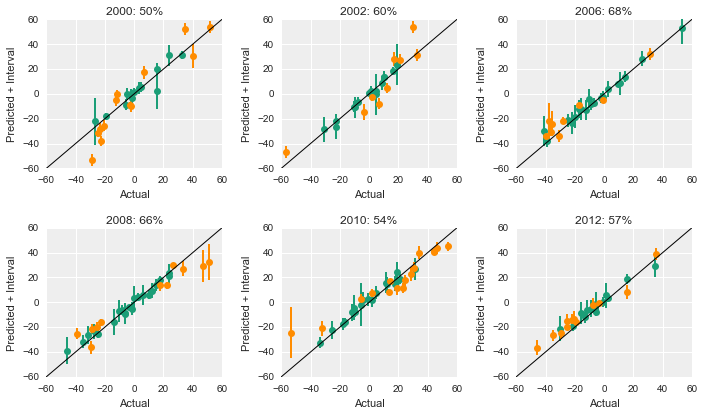

In [60]:
results_year = results_df.groupby("Year")

fignum = 0
for yr, year_df in results_year:
    covers = year_df['Covers99']
    err99 = year_df['PredSE']*2.54
    
    #Colors for predictions that cover or miss the truth.
    cover_color = dark2_colors[0]
    miss_color = "darkorange"
    
    fignum += 1    
    plt.subplot(2, 3, fignum)
    #Plot predictions that cover the truth.
    plt.errorbar(year_df.ix[covers, 'Result'],
                 year_df.ix[covers, 'Pred'],
                 yerr=err99[covers].values, fmt='o', c=cover_color, ecolor=cover_color)
    #Plot predictions that miss.
    plt.errorbar(year_df.ix[~covers, 'Result'],
                 year_df.ix[~covers, 'Pred'],
                 yerr=err99[~covers].values, fmt='o', c=miss_color, ecolor=miss_color)
        
    plt.xlim((-60,60))
    plt.ylim((-60,60))
    plt.plot([-60,60], [-60,60], linewidth=1, color='black')
    
    plt.title("%d: %d%%"%(yr, (np.mean(covers)*100).round()))
    plt.xlabel("Actual")
    plt.ylabel("Predicted + Interval")
    
plt.tight_layout()
plt.show()

The model is not very well-calibrated since the 99% prediction intervals contain the truth far less than 99% of the time. However, the predictions seem to track well with the truth, suggesting that our current model is **overconfident** and is giving predictive intervals that are too short. If we made the predictive intervals larger, then they would contain the truth closer to 99% of time time. But these intervals (ostensibly) take into account all of the variation *between* polls. Where is the extra variation coming from? That's what you should think about on your homework.

We can do the same sort of performance check with the binary "Dem or Republican" outcome. Compute the predictied probability of a Republican win using the normal approximation to our predictive distribution. Look at the probability that a vote percentage difference drawn from this distribution is greater than zero.

Since we saw that our predictive distributions were too narrow (resulting in low coverage) in the last part, try adding some additional variance to the predictive distribution.

In [61]:
from scipy.stats import norm

#`norm.cdf` returns the probability that a normal random variable is less than
#a particular value.
#Here we add 2 to the predicted distribution's standard deviation.
#What might this extra variation represent?
results_df['prob_rep_win'] = 1-norm.cdf(0, loc=results_df['Pred'], scale=results_df['PredSE']+2)

To see whether these probabilities look better calibrated, group the data by the predicted probability of a Republican win. See whether the empirical win percentage in each group seems to track with the predicted win percentage.

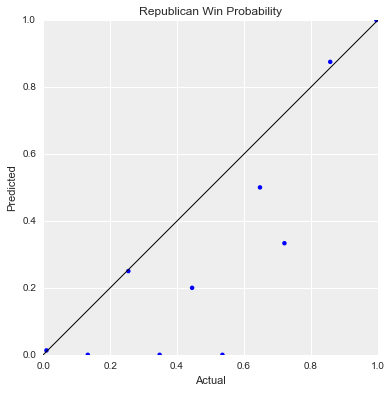

In [62]:
results_df['pred_group'] = pd.cut(results_df['prob_rep_win'], 10)
pred_groups = results_df.groupby("pred_group")
pred_prob = pred_groups['prob_rep_win'].aggregate(np.mean)
real_prob = pred_groups['Result'].aggregate(lambda x: np.mean(x > 0))

plt.scatter(pred_prob, real_prob)
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1], [0,1], linewidth=1, color='black')

plt.title("Republican Win Probability")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.gca().set_aspect('equal')

Adding some variation does seem to help in predicting win percentages. There are still some real issues for the close races near 50%. Those are also the most interesting ones for a forecaster's perspective, so this is a problem. Hopefully, you can do better on the homework!